In [1]:
import pandas as pd;
import numpy as np;

from sklearn.preprocessing import StandardScaler, MinMaxScaler;
from sklearn.model_selection import train_test_split;

import tensorflow as tf;
from tensorflow.keras import Sequential, Model, optimizers;
from tensorflow.keras.layers import Dense, Input, Dot;
from tensorflow.keras.losses import MeanSquaredError;

# Load Datasets

In [2]:
# Load wine ratings training dataset
wines = pd.read_csv('./wines_train.csv')
wines.head()

,wine_id,avg_rating,avg_price,astringent,bubbly,fragrant,zippy,pineapple,strawberry,crisp,...,variety_Xynisteri,variety_Yapincak,variety_Zibibbo,variety_Zierfandler,variety_Zierfandler-Rotgipfler,variety_Zinfandel,variety_Zlahtina,variety_Zweigelt,variety_Çalkarası,variety_Žilavka
0,1,5.0,31.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,2.0,24.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,5.0,45.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,5.0,35.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1.0,65.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87504 entries, 0 to 87503
Columns: 848 entries, wine_id to variety_Žilavka
dtypes: float64(2), int64(846)
memory usage: 566.1 MB


In [4]:
# Load taster profile training dataset
tasters = pd.read_csv('./taster_train.csv')
tasters.head()

,taster_id,num_reviews,avg_rating,avg_price,aged,angular,apple,approachable,apricot,aromatic,...,Xynisteri,Yapincak,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Çalkarası,Žilavka
0,1,6237,3.320988,38.642136,3.5,3.666667,2.758865,3.464646,2.975610,3.778947,...,0.0,0.0,0.0,0.0,0.0,2.802326,0.0,0.0,0.0,0.0
1,2,9497,3.189218,33.644835,3.5,2.250000,3.126394,2.980769,3.787879,3.906883,...,0.0,0.0,0.0,0.0,0.0,2.646667,0.0,1.5,0.0,0.0
2,3,27,3.407407,31.148148,0.0,0.000000,3.222222,0.000000,4.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,4,469,3.298507,22.313433,0.0,0.000000,3.327731,0.000000,4.068966,5.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,3.0,5.0,0.0,3.0
4,5,492,3.150407,28.132114,0.0,0.000000,2.446429,5.000000,1.789474,1.000000,...,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0


In [5]:
tasters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Columns: 851 entries, taster_id to Žilavka
dtypes: float64(849), int64(2)
memory usage: 126.4 KB


In [6]:
# Load actual ratings given by each taster for each wine they tasted.
taster_ratings_y = pd.read_csv('./taster_ratings_y.csv')
taster_ratings_y.head()

,taster_id,wine_id,rating
0,1,611,3
1,1,10892,1
2,1,16715,3
3,1,85145,1
4,1,41043,5


In [7]:
taster_ratings_y = taster_ratings_y.rename(columns={'rating':'actual_rating'})

In [8]:
taster_ratings_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96420 entries, 0 to 96419
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   taster_id      96420 non-null  int64
 1   wine_id        96420 non-null  int64
 2   actual_rating  96420 non-null  int64
dtypes: int64(3)
memory usage: 2.2 MB


Merge tasters and taster_ratings_y to create new data frame that has one row of taster data for each unique instance of the (taster_id,wine_id) combination.
* <b>Note</b>: Many rows will be duplicates with exception to the actual_rating.

In [9]:
# Merge taster_ratings_y and tasters left on 'taster_id'.
tasters_new = taster_ratings_y.merge(tasters, how='left', on='taster_id')
tasters_actual_rating_y = tasters_new.pop(item='actual_rating')
tasters_new.head()

,taster_id,wine_id,num_reviews,avg_rating,avg_price,aged,angular,apple,approachable,apricot,...,Xynisteri,Yapincak,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Çalkarası,Žilavka
0,1,611,6237,3.320988,38.642136,3.5,3.666667,2.758865,3.464646,2.97561,...,0.0,0.0,0.0,0.0,0.0,2.802326,0.0,0.0,0.0,0.0
1,1,10892,6237,3.320988,38.642136,3.5,3.666667,2.758865,3.464646,2.97561,...,0.0,0.0,0.0,0.0,0.0,2.802326,0.0,0.0,0.0,0.0
2,1,16715,6237,3.320988,38.642136,3.5,3.666667,2.758865,3.464646,2.97561,...,0.0,0.0,0.0,0.0,0.0,2.802326,0.0,0.0,0.0,0.0
3,1,85145,6237,3.320988,38.642136,3.5,3.666667,2.758865,3.464646,2.97561,...,0.0,0.0,0.0,0.0,0.0,2.802326,0.0,0.0,0.0,0.0
4,1,41043,6237,3.320988,38.642136,3.5,3.666667,2.758865,3.464646,2.97561,...,0.0,0.0,0.0,0.0,0.0,2.802326,0.0,0.0,0.0,0.0


In [10]:
tasters_actual_rating_y

0        3
1        1
2        3
3        1
4        5
        ..
96415    1
96416    1
96417    1
96418    4
96419    3
Name: actual_rating, Length: 96420, dtype: int64

In [11]:
tasters_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96420 entries, 0 to 96419
Columns: 852 entries, taster_id to Žilavka
dtypes: float64(849), int64(3)
memory usage: 626.8 MB


Merge wines and taster_ratings_y to create new dataframe that has one row of wine data for each unique instance of the (taster_id,wine_id) combination.
* <b>Note</b>: Many rows will be duplicates with exception to the actual_rating due to some wines being rated by multiple tasters.

In [12]:
# Merge taster_ratings_y and tasters left on 'taster_id'.
wines_new = taster_ratings_y.merge(wines, how='left', on='wine_id')
#tasters_actual_rating_y = tasters_new.pop(item='actual_rating')
wines_new

,taster_id,wine_id,actual_rating,avg_rating,avg_price,astringent,bubbly,fragrant,zippy,pineapple,...,variety_Xynisteri,variety_Yapincak,variety_Zibibbo,variety_Zierfandler,variety_Zierfandler-Rotgipfler,variety_Zinfandel,variety_Zlahtina,variety_Zweigelt,variety_Çalkarası,variety_Žilavka
0,1,611,3,3.0,40.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,10892,1,1.0,30.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,16715,3,3.0,35.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,85145,1,1.0,18.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,41043,5,5.0,62.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96415,19,8604,1,1.0,10.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96416,19,35194,1,1.0,19.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96417,19,39165,1,1.0,11.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96418,19,56834,4,4.0,15.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Content-based Filtering With Artificial Neural Networks

### Preparing the training data

In [13]:
np.array(tasters_actual_rating_y).reshape(-1,1)

array([[3],
       [1],
       [3],
       ...,
       [1],
       [4],
       [3]])

In [14]:
# Scaling the training data
scalerWines = StandardScaler()
wines_scaled = scalerWines.fit_transform(np.array(wines_new.iloc[:,3:])) # Not including 'taster_id','wine_id', 'actual_rating' in the training 

scalerTasters = StandardScaler() 
tasters_scaled = scalerTasters.fit_transform(np.array(tasters_new.iloc[:,4:])) # Not including 'taster_id', 'wine_id', 'num_reviews', 'avg_rating' in training

minmax = MinMaxScaler((-1,1))
taster_ratings_y_scaled = minmax.fit_transform(np.array(tasters_actual_rating_y).reshape(-1,1))

print(np.allclose(wines_new.iloc[:,3:], scalerWines.inverse_transform(wines_scaled)))
print(np.allclose(tasters_new.iloc[:,4:], scalerTasters.inverse_transform(tasters_scaled)))

True
True


Split data into train and test

In [15]:
wines_train, wines_test = train_test_split(wines_scaled, test_size=0.20, shuffle=True, random_state=1)
print(f"wines training data shape: {wines_train.shape}")
print(f"wines test data shape: {wines_test.shape}")

wines training data shape: (77136, 847)
wines test data shape: (19284, 847)


In [16]:
tasters_train, tasters_test = train_test_split(tasters_scaled, test_size=0.20, shuffle=True, random_state=1)
print(f"tasters training data shape: {tasters_train.shape}")
print(f"tasters test data shape: {tasters_test.shape}")

tasters training data shape: (77136, 848)
tasters test data shape: (19284, 848)


In [17]:
y_train, y_test = train_test_split(taster_ratings_y_scaled, test_size=0.20, shuffle=True, random_state=1)
print(f"wines training data shape: {y_train.shape}")
print(f"wines test data shape: {y_test.shape}")

wines training data shape: (77136, 1)
wines test data shape: (19284, 1)


### Neural Network Construction

In [18]:
num_taster_features = tasters_train.shape[1]
num_wines_features = wines_train.shape[1]

print(f"Number of taster features: {num_taster_features}")
print(f"Number of wine features: {num_wines_features}")

Number of taster features: 848
Number of wine features: 847


In [19]:
num_outputs = 32
tf.random.set_seed(1)

taster_NN = Sequential([
    Dense(units=256, activation ='relu'),
    Dense(units=128, activation ='relu'),
    Dense(units=num_outputs, activation ='linear')
])

wine_NN = Sequential([
    Dense(units=256, activation ='relu'),
    Dense(units=128, activation ='relu'),
    Dense(units=num_outputs, activation ='linear')
])

# create the taster input and point to the base network
input_taster = Input(shape=(num_taster_features))
v_taster = taster_NN(input_taster)
v_taster = tf.linalg.l2_normalize(v_taster, axis=1)

# create the item input and point to the base network
input_wine = Input(shape=(num_wines_features))
v_wine = wine_NN(input_wine)
v_wine = tf.linalg.l2_normalize(v_wine, axis=1)

# compute the dot product of the two vectors vu and vm
output = Dot(axes=1)([v_taster, v_wine])

# specify the inputs and output of the model
model = Model([input_taster, input_wine], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 848)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 847)]                0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32)                   254368    ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32)                   254112    ['input_2[0][0]']             
                                                                                              

In [20]:
# Calculate Cost using Mean Squared Error and Adam Optimizer
tf.random.set_seed(1)
cost_fn = MeanSquaredError()
opt = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn)

In [21]:
tf.random.set_seed(1)
history = model.fit([tasters_train, wines_train], y_train, validation_split = 0.25, epochs=15)

Epoch 1/15
1808/1808 [==============================] - 6s 3ms/step - loss: 0.0464 - val_loss: 0.0191
Epoch 2/15
1808/1808 [==============================] - 6s 3ms/step - loss: 0.0143 - val_loss: 0.0138
Epoch 3/15
1808/1808 [==============================] - 6s 3ms/step - loss: 0.0098 - val_loss: 0.0119
Epoch 4/15
1808/1808 [==============================] - 4s 2ms/step - loss: 0.0077 - val_loss: 0.0102
Epoch 5/15
1808/1808 [==============================] - 5s 3ms/step - loss: 0.0064 - val_loss: 0.0093
Epoch 6/15
1808/1808 [==============================] - 5s 3ms/step - loss: 0.0056 - val_loss: 0.0087
Epoch 7/15
1808/1808 [==============================] - 5s 3ms/step - loss: 0.0048 - val_loss: 0.0082
Epoch 8/15
1808/1808 [==============================] - 5s 3ms/step - loss: 0.0043 - val_loss: 0.0073
Epoch 9/15
1808/1808 [==============================] - 5s 3ms/step - loss: 0.0040 - val_loss: 0.0077
Epoch 10/15
1808/1808 [==============================] - 5s 3ms/step - loss: 0.003

In [22]:
import matplotlib.pyplot as plt;

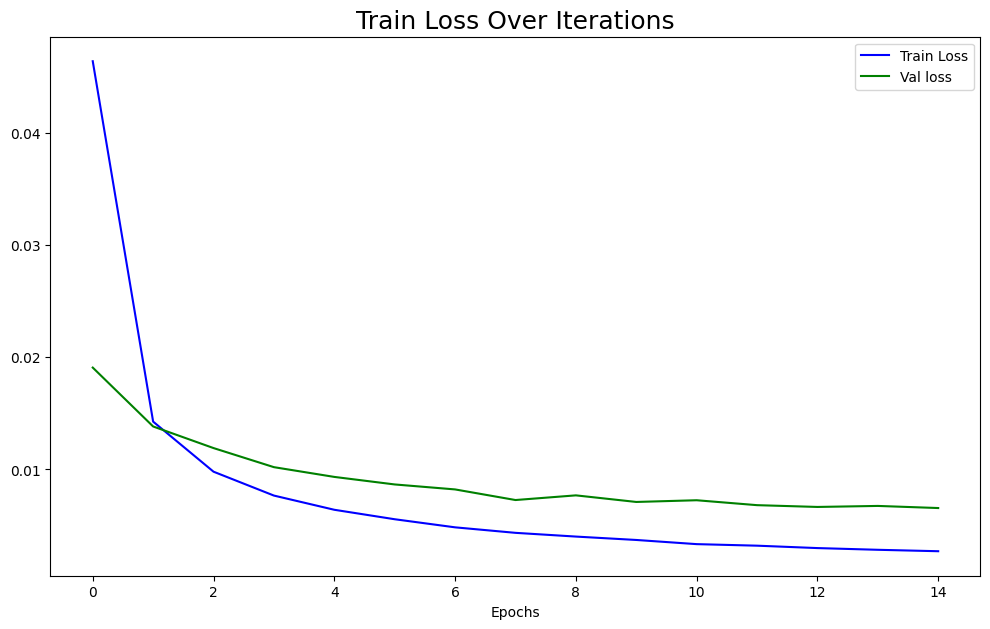

In [23]:
plt.figure(figsize=(12,7))
plt.plot(history.history['loss'], label = 'Train Loss', color = 'b')
#plt.plot(history.history['accuracy'], label = 'Train Accuracy', linestyle = 'dashed', color = 'b')
plt.plot(history.history['val_loss'], label = 'Val loss', color = 'g')
#plt.plot(history.history['val_accuracy'], label = 'Val Accuracy', linestyle = 'dashed', color = 'g')
plt.title('Train Loss Over Iterations', fontsize = 18)
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [24]:
# Evaluate the model to determine lost on the test data
model.evaluate([tasters_test, wines_test], y_test)

603/603 [==============================] - 0s 557us/step - loss: 0.0070


0.006955504883080721

## Predictions

### Prediction for brand new taster

Let's say that a new taster is added to the data and this taster has a strong preference for fruity, aged, Pinot Noirs. 

In [25]:
# Find the maximum existing taster_id
max_taster_id = tasters_new['taster_id'].max()

In [26]:
# Create a new taster vector for the new tester
new_taster_vector = np.zeros((1, num_taster_features))  # Initialize to all zeros

# Assign new taster_id
new_taster_id = max_taster_id + 1

In [27]:
# Update the columns for fruity, aged, and variety_PinotNoir
new_taster_vector[:, tasters_new.columns.get_loc('fruity')] = 2.0  # Replace fruity_index with the actual index in the taster vector
new_taster_vector[:, tasters_new.columns.get_loc('aged')] = 5.0  # Replace aged_index with the actual index in the taster vector
new_taster_vector[:, tasters_new.columns.get_loc('earthy')] = 5.0  # Replace variety_PinotNoir_index with the actual index

In [28]:
# Replicate the new_taster_vector to match the number of wines in the dataset
num_wines = wines_scaled.shape[0]
replicated_taster_vectors = np.tile(new_taster_vector, (num_wines, 1))

In [29]:
# Scale the new taster vector
scaled_new_taster_vector = scalerTasters.transform(replicated_taster_vectors)

In [30]:
# Predict the rating using the trained model
predicted_rating = model.predict([scaled_new_taster_vector, wines_scaled])

3014/3014 [==============================] - 2s 488us/step


In [31]:
# Unscale prediction
predicted_rating_unscaled = minmax.inverse_transform(predicted_rating)

In [32]:
# Predicted rating for user
print("Predicted Rating for the New Taster:", predicted_rating_unscaled)

Predicted Rating for the New Taster: [[3.6510262]
 [1.0363561]
 [3.0352974]
 ...
 [1.0259393]
 [4.031225 ]
 [3.0351818]]


In [33]:
len(predicted_rating_unscaled)

96420

In [34]:
wine_ids = wines_new['wine_id'].tolist()
len(wine_ids)

96420

In [35]:
wines_unscaled = scalerWines.inverse_transform(wines_scaled)

In [36]:
wines_predictions_df = pd.DataFrame(data = wines_unscaled, columns= wines_new.iloc[:,3:].columns)
wines_predictions_df.insert(0,'predicted_rating',predicted_rating_unscaled)
wines_predictions_df.insert(0,'wine_id',wine_ids)
wines_predictions_df= wines_predictions_df.drop_duplicates(subset='wine_id', keep='first')
wines_predictions_df = wines_predictions_df.sort_values(by='predicted_rating', ascending=False)

In [37]:
wines_predictions_df

,wine_id,predicted_rating,avg_rating,avg_price,astringent,bubbly,fragrant,zippy,pineapple,strawberry,...,variety_Xynisteri,variety_Yapincak,variety_Zibibbo,variety_Zierfandler,variety_Zierfandler-Rotgipfler,variety_Zinfandel,variety_Zlahtina,variety_Zweigelt,variety_Çalkarası,variety_Žilavka
39214,67015,4.990663,5.0,33.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41174,84016,4.989923,5.0,60.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15874,71689,4.989642,5.0,36.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89734,70776,4.989528,5.0,31.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15941,41237,4.989389,5.0,28.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16061,49079,1.001907,1.0,7.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15902,41193,1.001840,1.0,9.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16205,32046,1.001728,1.0,7.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16180,70692,1.001640,1.0,7.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
